PCA-NMF Experimentation + Class Variance Experimentations

In [1]:
import os
from random import sample
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Must be set before importing TF to supress messages
os.environ["CUDA_VISIBLE_DEVICES"]= '1'

import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger
import numpy as np
from utils.loader import DataLoader
from utils.tools import test_model
from utils.data_sampler import CustomDataGenerator, CustomIterator
from utils.configs import config
from typing import List
import sklearn
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import networkx as nx
import community
import collections
import matplotlib

In [2]:
# Load Test-Set
img_height = 224
img_width = 224
batch_size = 1

# Set augmentation and pre-processing
test_datagen = CustomDataGenerator(
                    preprocessing_function=tf.keras.applications.vgg16.preprocess_input, dtype=tf.float32)

# Load ImageNet dataset with the VGG augmentation
loader = DataLoader(batch_size, (img_height, img_width))
test_set = loader.load_test_set(aug_test=test_datagen, set_batch_size=False)

Loading test set...
Found 48238 images belonging to 1000 classes.


In [3]:
# Load Pre-Trained model
model = tf.keras.models.load_model('models/vgg_trained')

In [3]:
# Get list of class folders
folder_names = list(os.walk(os.path.join(config['image_net_path'], config['test_path'])))[0][1]

In [4]:
# Get conversion of folder to names
conv_table = pd.read_table(os.path.join(config['externals'], 'imagenet1k_folder2labels.txt'), names=['folder', 'num', 'label'], delim_whitespace=True)
label_dict = dict(zip(list(conv_table['folder']), list(conv_table['label'])))

In [ ]:
# Create model to ouput activation at end of block 4 (clipped model)
layer_name = 'block4_conv3'
intermediate_layer_model = tf.keras.Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)

In [6]:
# Target Classes
ave = ['n01534433', 'n01608432', 'n01806143', 'n01820546', 'n01833805', 'n01855672', 'n02012849'] 
kitchen = ['n03887697', 'n03207941','n02906734', 'n04131690', 'n03775546', 'n04553703', 'n03207743']
dogs = ['n02085620', 'n02085782', 'n02085936', 'n02087046', 'n02094114', 'n02095570', 'n02096294']
ord_dict = {'ave':ave, 'kitchen':kitchen, 'dog':dogs}

Load Superordinate List and Class Accuracies

In [ ]:
ord_dict = {}
att_dict = {}
for ord in list(os.walk(os.path.join('external_files', 'imagenet_superordinates')))[0][2]:
    ord_dict[ord.split('_')[0]] = list(pd.read_csv(os.path.join('external_files', 'imagenet_superordinates', ord))['wnid'])

In [ ]:
with open('external_files/generated_saves/class_var.pkl', 'rb') as f:
    class_var  = pickle.load(f)
with open('external_files/generated_saves/class_var_pca.pkl', 'rb') as f:
    class_var_pca  = pickle.load(f)
with open('external_files/generated_saves/class_var_pca_comp.pkl', 'rb') as f:
    class_var_pca_comp  = pickle.load(f)
with open('external_files/generated_saves/class_acc.pkl', 'rb') as f:
    class_acc_ = pickle.load(f)

NMF-PCA

In [ ]:
# Extract NMF topics from activations
n_comp = 3
model = sklearn.decomposition.NMF(n_components=n_comp, init='nndsvda', random_state=0, max_iter=300)
o_dict = {}
w_dict = {}

for j, od in enumerate(ord_dict.keys()): # For each superordinate
    print(f'----{j}-----')
    arr_dict = {}
    for i in range(n_comp):
        arr_dict[i] = []
    ov_arr = []
    w_arr = []
    for i, cl in enumerate(ord_dict[od]): # For each class in the superordinate
        if i%20 ==0:
            print(f"{i}/{len(ord_dict[od])}")
        test_set.set_target_sampling([cl], [1]) # Set the test-set to only output samples from the class
        activations = intermediate_layer_model.predict(test_set, steps=test_set.n//test_set.batch_size, verbose=0)
        activations = tf.reshape(activations, [activations.shape[0],-1]).numpy() # Flatten activations
        W = model.fit_transform(activations) # Run NMF
        H = model.components_
        for i in range(n_comp): # Store each topic vector seperately
            arr_dict[i].append(H[i, :].T)
        w_arr.append(np.var(W, axis=0)) # Store the average variance of each topic assignment (Not Used)
    for i in range(n_comp): # For each topic vector list we concat them
        arr_dict[i] = np.vstack(arr_dict[i])
    w_arr = np.vstack(w_arr)
    w_dict[od] = np.mean(w_arr, axis=0)

    # One-eigenvalue PCA on the NMF topic vectors
    pca = PCA(1)
    for i in range(n_comp):
        el = arr_dict[i] - np.mean(arr_dict[i], axis=0)
        reduced = pca.fit(el)
        ov_arr.append(reduced.explained_variance_ratio_[0])
    o_dict[od] = ov_arr

In [ ]:
# Get mean superordinate accuracies
acc_dict = {}
for od in o_dict.keys():
    acc = []
    for cl in ord_dict[od]:
        acc.append(class_acc_[label_dict[cl]])
    acc_dict[od] = np.mean(acc)

In [13]:
# Sort dictionaries to be in same order
o_dict = dict(sorted(o_dict.items()))
w_dict = dict(sorted(w_dict.items()))
acc_dict = dict(sorted(acc_dict.items()))

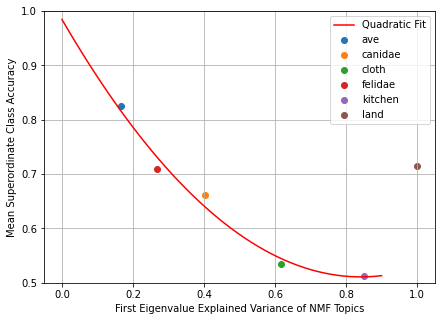

In [21]:
# Plot
x = np.array(list(k[0] for k in o_dict.values())).reshape(-1, 1)
y = np.array(list(acc_dict.values())).reshape(-1, 1)
x_quad = np.hstack([x, x**2])
x_new = np.linspace(0, 0.9, 50).reshape(-1, 1)
x_new = np.hstack([x_new, x_new**2])
reg = sklearn.linear_model.LinearRegression().fit(x_quad[:-1, :], y[:-1, :])

fig, ax = plt.subplots(figsize=(7,5))
for i, cl in enumerate(o_dict.keys()):
    ax.scatter(x[i], y[i], label=cl)
ax.plot(x_new[:, 0], reg.predict(x_new), 'r', label='Quadratic Fit')
ax.grid()
ax.set_xlabel('First Eigenvalue Explained Variance of NMF Topics')
ax.set_ylabel('Mean Superordinate Class Accuracy')
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([0.5, 1])
plt.legend(loc='upper right')
fig.savefig('pca_nmf_superordinates.png', dpi=300)

In [69]:
with open('nmf_ord_results.pkl', 'wb') as f:
    pickle.dump(o_dict, f)

In [13]:
with open('external_files/generated_saves/nmf_ord_results.pkl', 'rb') as f:
    o_dict  = pickle.load(f)

Clustering Experiments

In [77]:
# count_dict = {}
# for k,v in ord_dict.items():
#     count = 0
#     for cl in v:
#         if cl in classes:
#             count+=1
#     count_dict[k] = count

In [ ]:
folder_names = sorted(folder_names)

In [10]:
# Load semantic embeddings
sem_vec = np.load('external_files/imagenet2vec_1k.npy')
sem_dict = {}
for cl in folder_names:
    sem_dict[cl] = sem_vec[folder_names.index(cl)]

In [ ]:
# Cosine Similarity Gram Matrix for all ImageNet classes
cosine_sim = np.zeros((1000, 1000))
for i, cl in enumerate(folder_names):
    for j, cl2 in enumerate(folder_names):
        cosine_sim_score = np.dot(sem_dict[cl], sem_dict[cl2])/(np.linalg.norm(sem_dict[cl])*np.linalg.norm(sem_dict[cl2]))
        cosine_sim[i, j] = cosine_sim_score

In [146]:
# Cosine Similarity Gram Matrix for superordinate classes
superordinate = 'ave'

cosine_sim = np.zeros((len(ord_dict[superordinate]), len(ord_dict[superordinate])))
for i, cl in enumerate(ord_dict[superordinate]):
    for j, cl2 in enumerate(ord_dict[superordinate]):
        cosine_sim_score = np.dot(sem_dict[cl], sem_dict[cl2])/(np.linalg.norm(sem_dict[cl])*np.linalg.norm(sem_dict[cl2]))
        cosine_sim[i, j] = cosine_sim_score

In [147]:
# Construct edge dictionary to feed to NetX to form the graph
new_od = {}
for row in range(cosine_sim.shape[0]):
    index = list(np.where(cosine_sim[row, :]>0.05)[0])
    index.remove(row)
    index = [[ord_dict[superordinate][idx],cosine_sim[row, idx]] for idx in index]
    new_od[ord_dict[superordinate][row]] = index

In [148]:
# Construct Graph
g = nx.Graph()
g.add_nodes_from(list(new_od.keys()))
for k, v in new_od.items():
    for entry in v:
        g.add_edge(k, entry[0], weight=entry[1])

Affinity Prop Clustering

In [38]:
nn = len(g.nodes)
mat = np.empty((nn, nn), dtype=float)
mat.fill(-100.0)
np.fill_diagonal(mat, -0.0)
preds = nx.jaccard_coefficient(g, g.edges)
for u, v, j in preds:
    mat[ord_dict['kitchen'].index(u),ord_dict['kitchen'].index(v)] = -100 * (1 - j)

In [ ]:
from sklearn.cluster import AffinityPropagation
af = AffinityPropagation(preference=-100, affinity="precomputed")
lab = af.fit_predict(mat)
len(np.unique(lab))

In [40]:
cluster_dict = {}
for idx in range(len(np.unique(lab))):
    cluster_dict[idx] = np.where(af.labels_==idx)[0].tolist()
for k,v in cluster_dict.items():
    cluster_dict[k] = [folder_names[idx] for idx in v]

Community Clustering

In [188]:
partition = community.best_partition(g)
values = [partition.get(node) for node in g.nodes()]
counter=collections.Counter(values)
print(counter)

Counter({0: 22, 2: 22, 1: 16})


In [150]:
groups_dict = {}
nodes_list = list(g.nodes())
for i, v in enumerate(values):
    if v not in groups_dict:
        groups_dict[v] = []
    groups_dict[v].append(label_dict[nodes_list[i]])

In [ ]:
si2 = {}

for k, v in groups_dict.items():
    cosine_sim2 = np.zeros((len(groups_dict[k]), len(groups_dict[k])))
    for i, cl in enumerate(groups_dict[k]):
        for j, cl2 in enumerate(groups_dict[k]):
            cosine_sim_score = np.dot(sem_dict[cl], sem_dict[cl2])/(np.linalg.norm(sem_dict[cl])*np.linalg.norm(sem_dict[cl2]))
            cosine_sim2[i, j] = cosine_sim_score
    si2[k] = cosine_sim2

In [ ]:
for k, v in si2.items(): # Avian scores ->> group 3 chosen
    print(f'{k}: {np.mean(si2[k])}, len:{len(si2[k])}')

2: 0.6337667578891114, len:29
0: 0.5707850256118893, len:22
3: 0.6647788784941848, len:7
1: 0.8086569011211395, len:2


In [ ]:
for k, v in si2.items(): # Kitchen scores ->> group 5 chosen
    print(f'{k}: {np.mean(si2[k])}, len:{len(si2[k])}')

0: 1.0, len:1
1: 0.7145667331559318, len:7
2: 1.0, len:1
3: 0.6686445011032952, len:9
4: 0.6384055829048156, len:10
5: 0.7235228115198563, len:7


In [ ]:
# cluster_dict2 = {}
# for k,v in cluster_dict.items():
#     cluster_dict2[k] = [cl for cl in cluster_dict[k] if label_dict_rev[cl] in ord_dict['kitchen']]

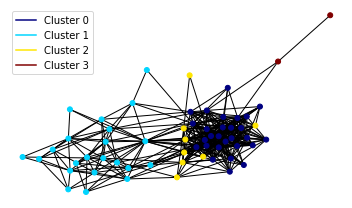

In [158]:
ColorLegend = {'Cluster 0': 0,'Cluster 1': 1,'Cluster 2': 2,'Cluster 3': 3}
jet = cm = plt.get_cmap('jet')
cNorm  = matplotlib.colors.Normalize(vmin=0, vmax=max(values))
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=jet)

# Using a figure to use it as a parameter when calling nx.draw_networkx
f = plt.figure(1, figsize=(5,3))
ax = f.add_subplot(1,1,1)
for label in ColorLegend:
    ax.plot([0],[0],color=scalarMap.to_rgba(ColorLegend[label]),label=label)

# Just fixed the color map
nx.draw_networkx(g ,pos=sp, cmap = jet, vmin=0, vmax= max(values),node_color=values,with_labels=False,ax=ax, node_size=25, )

# Setting it to how it was looking before.                                                                                                              
plt.axis('off')
f.set_facecolor('w')

plt.legend()

f.tight_layout()
plt.savefig('Avian_Cluster_Graph.png')
plt.show()

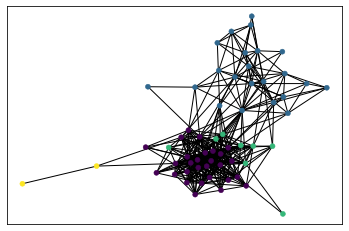

In [167]:
sp = nx.spring_layout(g)
nx.draw_networkx(g, pos=sp, with_labels=False, node_size=25, node_color=values, linewidths=0.5,)
# plt.axes('off')
plt.show()

Misc Experiments (Not used in report)

Basic Variance of Activations

In [ ]:
basic_var_dict = {}
for i, cl in enumerate(label_dict.keys()):
    if i % 25 == 0:
        print(f'{i}/{len(label_dict)}')
    test_set.set_target_sampling([cl], [1])
    activations = intermediate_layer_model.predict(test_set, steps=test_set.n//test_set.batch_size, verbose=0)
    var = np.var(activations, axis =(1,2)) # Var within each filter
    var = np.var(var, axis=-1) # Var across variance of filters
    var = np.mean(var) # Mean variance across all inter-class samples
    basic_var_dict[label_dict[cl]] = var

In [21]:
basic_var_dict = dict(sorted(basic_var_dict.items(), key=lambda item: item[1], reverse=True))

In [69]:
with open('class_var.pkl', 'wb') as f:
    pickle.dump(basic_var_dict, f)

PCA Version

In [15]:
var_dict = {0.75:[], 0.85:[], 0.95:[]}
od = 'kitchen'
for i, cl in enumerate(ord_dict[od]):
    if i%20 ==0:
        print(f"{i}/{len(ord_dict[od])}")
    test_set.set_target_sampling([cl], [1])
    activations = intermediate_layer_model.predict(test_set, steps=test_set.n//test_set.batch_size, verbose=0)
    activations = tf.reshape(activations, [activations.shape[0],-1]).numpy()
    activations = activations - np.mean(activations, axis=0)

    for pr in [0.75, 0.85, 0.95]:
        pca = PCA(pr)
        reduced = pca.fit(activations)
        var_dict[pr].append(pca.n_components_)

0/35
20/35


In [13]:
activations.shape

(50, 401408)

In [16]:
for pr in var_dict.keys():
    var_dict[pr] = np.mean(var_dict[pr])

In [17]:
var_dict

{0.75: 28.771428571428572, 0.85: 34.97142857142857, 0.95: 42.42857142857143}

In [ ]:
var_dict = {}
pca = PCA(10)
# Perform PCA per class
for i, cl in enumerate(label_dict.keys()):
    if i % 25 == 0:
        print(f'{i}/{len(label_dict)}')
    test_set.set_target_sampling([cl], [1])
    activations = intermediate_layer_model.predict(test_set, steps=test_set.n//test_set.batch_size, verbose=0)
    activations = tf.reshape(activations, [activations.shape[0],-1]).numpy()
    activations = activations - np.mean(activations, axis=0)
    reduced = pca.fit(activations)
    var_dict[label_dict[cl]] = sum(reduced.explained_variance_ratio_)

In [79]:
with open('class_var_pca_centered.pkl', 'wb') as f:
    pickle.dump(var_dict, f)

In [ ]:
var_dict = dict(sorted(var_dict.items(), key=lambda item: item[1], reverse=False))

In [16]:
class_var_pca = var_dict.copy()

Comparisons

In [6]:
var_pca_comp = set(list(class_var_pca_comp.keys())[:200]) # Explained var threshold set with 50% cap 
var_pca = set(list(class_var_pca.keys())[:200]) # First 5 PC's explained variance sum
base_var = set(list(class_var.keys())[:200]) # Basic variance
class_acc = set(list(class_acc_.keys())[:200]) # Per class accuracies 

In [13]:
overlap = class_acc.intersection(var_pca)
overlap2 = class_acc.intersection(var_pca_comp)
overlap3 = class_acc.intersection(base_var)

In [17]:
for cl in ord_dict.keys():
    print(cl, len(var_pca_comp.intersection(set([label_dict[k] for k in ord_dict[cl]]))))

ave 0
canidae 80
felidae 11
kitchen 0
cloth 0
land 15


Main Experiment Comparisons

In [18]:
print(f'Overlap of lowest 200 (accuracy) classes to highest 200 basic variance:   {len(class_acc.intersection(base_var))}')
print(f'Overlap of lowest 200 (accuracy) classes to lowest 200 cumulative variance of first 5 PCs:   {len(class_acc.intersection(var_pca))}')
print(f'Overlap of lowest 200 (accuracy) classes to lowest 200 first N PCs w/50% expained variance:   {len(class_acc.intersection(var_pca_comp))}')

Overlap of lowest 200 (accuracy) classes to highest 200 basic variance:   42
Overlap of lowest 200 (accuracy) classes to lowest 200 cumulative variance of first 5 PCs:   30
Overlap of lowest 200 (accuracy) classes to lowest 200 first N PCs w/50% expained variance:   24


In [19]:
x_base, x_pca, x_pca_comp, y = [], [], [], []
for cl in list(overlap3):
    cl_conv = cl #label_dict[cl]
    x_base.append(class_var[cl_conv])
    x_pca.append(class_var_pca[cl_conv])
    x_pca_comp.append(class_var_pca_comp[cl_conv])
    y.append(class_acc_[cl_conv])

In [20]:
x_pca = (np.array(x_pca) - np.min(np.array(x_pca)))/(np.max(np.array(x_pca)) - np.min(np.array(x_pca)))
x_base = (np.array(x_base) - np.min(np.array(x_base)))/(np.max(np.array(x_base)) - np.min(np.array(x_base)))

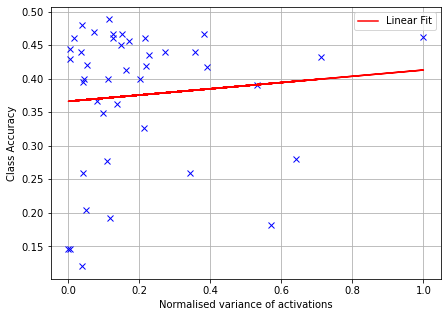

In [21]:
x_base = np.array(x_base)
reg = sklearn.linear_model.LinearRegression().fit(x_base.reshape(-1, 1), y)

fig, ax = plt.subplots(figsize=(7,5))
ax.plot(x_base, y, 'bx')
ax.plot(x_base, reg.predict(x_base.reshape(-1, 1)), 'r', label='Linear Fit')
ax.grid()
ax.set_xlabel('Normalised variance of activations')
ax.set_ylabel('Class Accuracy')
plt.legend(loc='upper right')
#fig.savefig('base_var_plot.png')

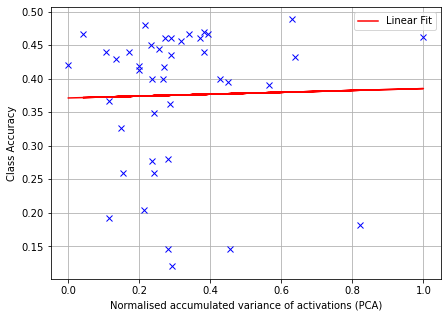

In [22]:
x_pca = np.array(x_pca)
reg = sklearn.linear_model.LinearRegression().fit(x_pca.reshape(-1, 1), y)

fig, ax = plt.subplots(figsize=(7,5))
ax.plot(x_pca, y, 'bx')
ax.plot(x_pca, reg.predict(x_pca.reshape(-1, 1)), 'r', label='Linear Fit')
ax.grid()
ax.set_xlabel('Normalised accumulated variance of activations (PCA)')
ax.set_ylabel('Class Accuracy')
plt.legend(loc='upper right')
#fig.savefig('pca_var_plot.png')

Text(0, 0.5, 'Class Accuracy')

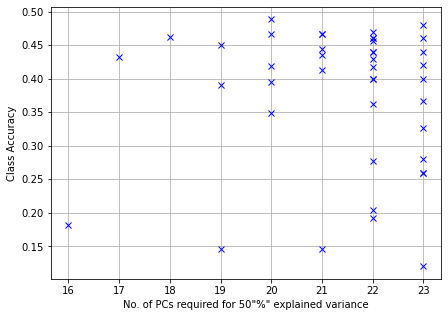

In [78]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(x_pca_comp, y, 'bx')
ax.grid()
ax.set_xlabel('No. of PCs required for 50"%" explained variance')
ax.set_ylabel('Class Accuracy')
#fig.savefig('pca_comp_var_plot.png')